In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras import losses, optimizers
from tensorflow.keras import activations
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
import os
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

In [2]:
batch_size = 32
IMG_SIZE = (64,64)
data_dir = "Face Mask Dataset"
AUTOTUNE = tf.data.experimental.AUTOTUNE

The dataset is available at : https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset

In [3]:
def get_dataset(mode,batch_size=None):
    if mode == "train":
        ds = tf.keras.preprocessing.image_dataset_from_directory(
            os.path.join(data_dir,"Train"),
            batch_size=batch_size,
            image_size = IMG_SIZE)
    elif mode == "valid":
        ds = tf.keras.preprocessing.image_dataset_from_directory(
            os.path.join(data_dir,"Validation"),
            batch_size=800,
            image_size = IMG_SIZE)
    elif mode == "test":
        ds = tf.keras.preprocessing.image_dataset_from_directory(
            os.path.join(data_dir,"Test"),
            batch_size=992,
            image_size = IMG_SIZE)
    return ds

In [4]:
train_ds = get_dataset("train",batch_size)
val_ds = get_dataset("valid")
test_ds = get_dataset("test")

Found 10000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.
Found 992 files belonging to 2 classes.


In [5]:
classes_names = train_ds.class_names
num_classes = len(classes_names)
print(classes_names)

['WithMask', 'WithoutMask']


We are using MobileNetV2 because it is a lightweight model, very suitable for real-time application.

In [6]:
def make_model(input_shape, num_classes):
    inputs = layers.Input(shape = input_shape)
    inputs = preprocess_input(inputs)
    base_model = MobileNetV2(include_top = False, input_tensor = inputs)
    features_extractor = base_model.layers[-1].output
    features_extractor = layers.GlobalAveragePooling2D()(features_extractor)
    features_extractor = layers.Dropout(0.5)(features_extractor)
    if num_classes == 2 :
        activation = "sigmoid"
        units = 1
    else :
        activation = "softmax"
        units = num_classes
    classifier = layers.Dense(units, activation = activation)(features_extractor)
    return Model(inputs = inputs, outputs = classifier)


In [7]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [8]:
model = make_model(IMG_SIZE + (3,), num_classes)

In [ ]:
model.summary()

In [10]:
adam = optimizers.Adam(lr=0.0001, decay=1e-6)
model.compile(optimizer=adam,
            loss="binary_crossentropy",
            metrics=['accuracy'])
save_path = 'mask_classification.h5'
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint(save_path, monitor='val_accuracy', mode='max', save_best_only=True)
epochs = 20
history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=[es, mc])

Epoch 1/20
313/313 [==============================] - 19s 62ms/step - loss: 0.1944 - accuracy: 0.9184 - val_loss: 0.2305 - val_accuracy: 0.9325
Epoch 2/20
313/313 [==============================] - 18s 57ms/step - loss: 0.0450 - accuracy: 0.9853 - val_loss: 0.0316 - val_accuracy: 0.9850
Epoch 3/20
313/313 [==============================] - 19s 60ms/step - loss: 0.0323 - accuracy: 0.9890 - val_loss: 0.0651 - val_accuracy: 0.9800
Epoch 4/20
313/313 [==============================] - 18s 58ms/step - loss: 0.0171 - accuracy: 0.9948 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 5/20
313/313 [==============================] - 17s 56ms/step - loss: 0.0118 - accuracy: 0.9964 - val_loss: 2.4007e-04 - val_accuracy: 1.0000
Epoch 6/20
313/313 [==============================] - 18s 57ms/step - loss: 0.0066 - accuracy: 0.9984 - val_loss: 5.1573e-04 - val_accuracy: 1.0000
Epoch 7/20
313/313 [==============================] - 18s 59ms/step - loss: 0.0060 - accuracy: 0.9981 - val_loss: 9.2963e-04 - v

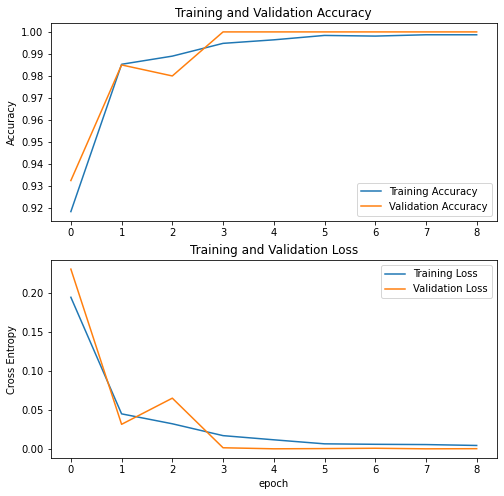

In [11]:
plot_history(history)

In [12]:
model = load_model("mask_classification.h5")

In [13]:
model.evaluate(test_ds)

1/1 [==============================] - 0s 2ms/step - loss: 0.0219 - accuracy: 0.9960


[0.0218769833445549, 0.9959677457809448]

In [14]:
def get_prediction(image_batch,model):
    predictions = model.predict_on_batch(image_batch).flatten()
    predictions = tf.round(predictions)
    return predictions.numpy().astype(int)

In [15]:
def plot_example(predictions):
    plt.figure(figsize=(20, 25))
    for i in range(32):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(image_batch[i]/255)
        if classes_names[label_batch[i]] == classes_names[predictions[i]] : 
            color = "green"
        else:
            color = "red"
        plt.title(f'true : {classes_names[label_batch[i]]} / pred: {classes_names[predictions[i]]}',color = color)
        plt.axis("off")

In [16]:
def plot_confusion_matrix(labels, predictions):
    con_mat = confusion_matrix(labels, predictions)
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

    con_mat_df = pd.DataFrame(con_mat_norm,
                        index = classes_names, 
                        columns = classes_names)
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [17]:
iterator = iter(test_ds)
image_batch, label_batch = iterator.next()
predictions = get_prediction(image_batch,model)

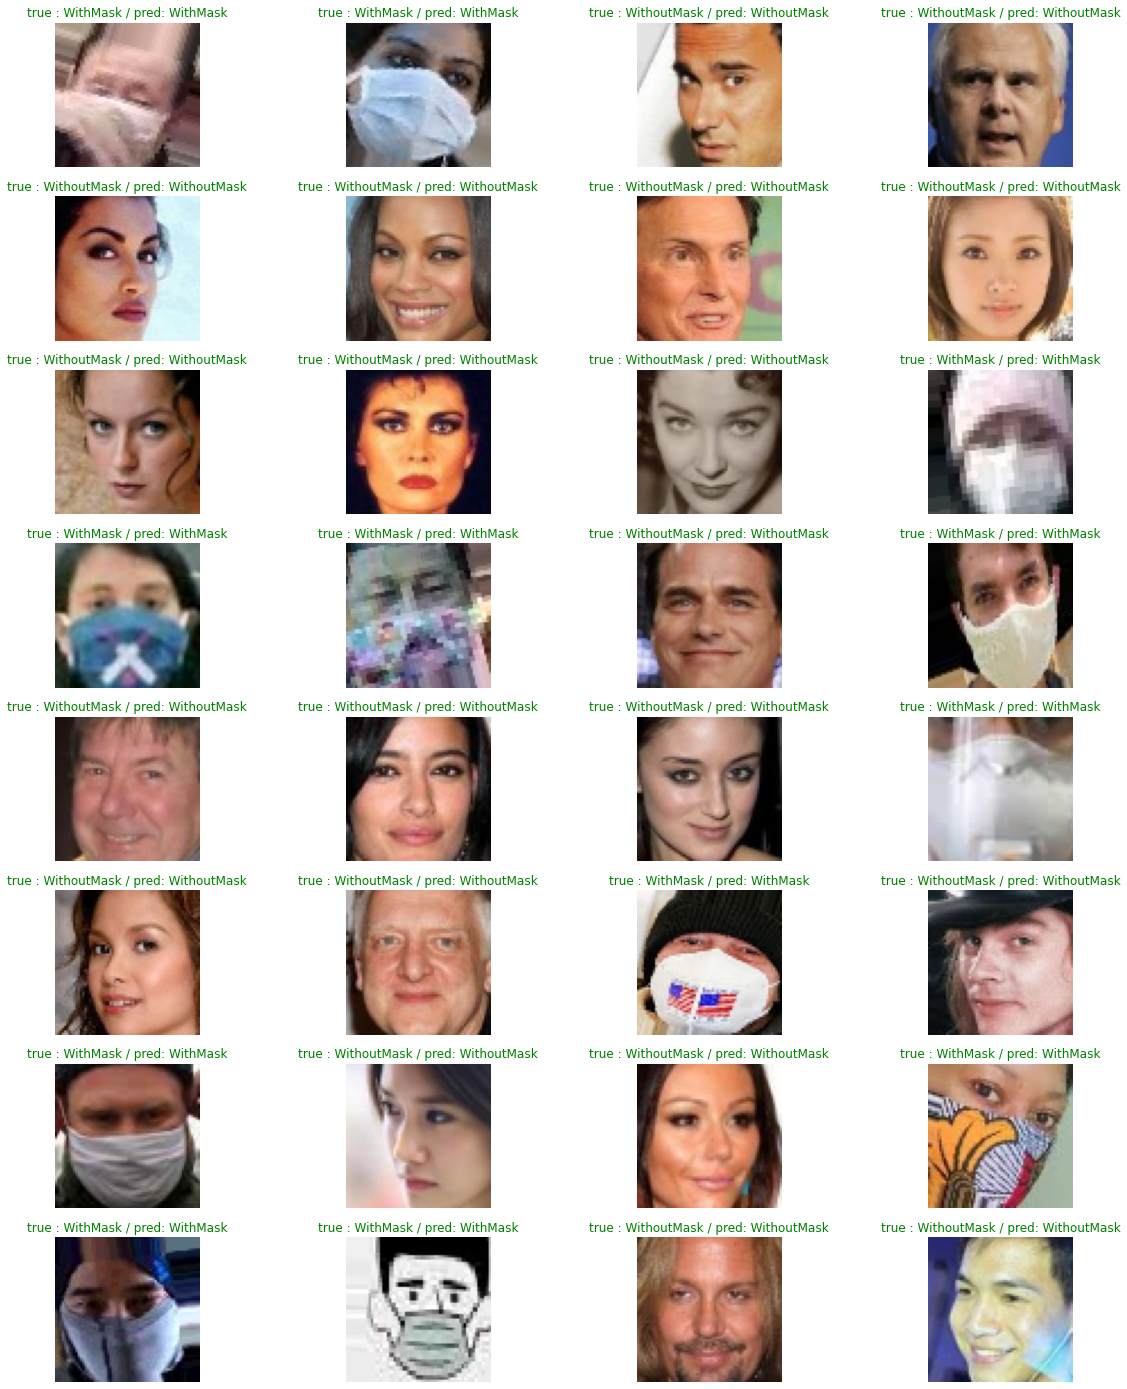

In [18]:
plot_example(predictions)

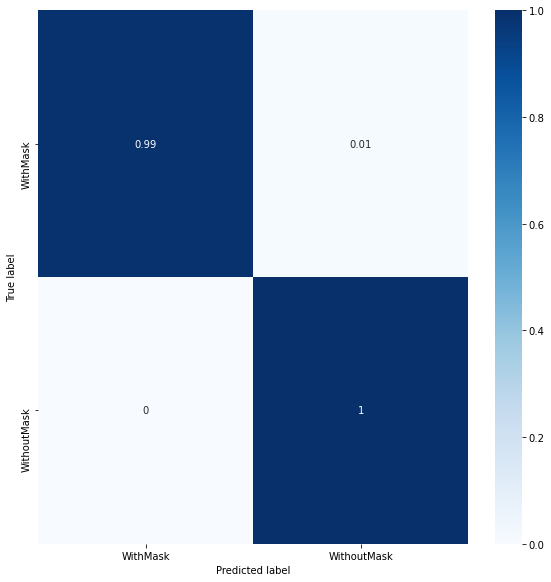

In [19]:
plot_confusion_matrix(label_batch,predictions)